In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

c:\Users\Lenono\anaconda3\envs\pytorch_basics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Lenono\anaconda3\envs\pytorch_basics\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## Download dataset

In [2]:
ROOT_DATA_DIR = "FashionMNISTDir1"

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()
    )


test_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train = False, ## <<< Test data
    download = True,
    transform = transforms.ToTensor()
    )

100%|██████████| 26421880/26421880 [00:20<00:00, 1282572.20it/s]


Extracting FashionMNISTDir1\FashionMNIST\raw\train-images-idx3-ubyte.gz to FashionMNISTDir1\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 5078347.73it/s]


Extracting FashionMNISTDir1\FashionMNIST\raw\train-labels-idx1-ubyte.gz to FashionMNISTDir1\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:06<00:00, 702819.11it/s] 


Extracting FashionMNISTDir1\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to FashionMNISTDir1\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 1030362.52it/s]


Extracting FashionMNISTDir1\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to FashionMNISTDir1\FashionMNIST\raw



In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [4]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [5]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
    }

## Visualize one sample

In [6]:
def view_sample_img(data, index, label_map):
    plt.imshow(data.data[index], cmap="gray")
    plt.title(f"data label: {label_map[data.targets[index].item()]}")
    plt.axis("off")

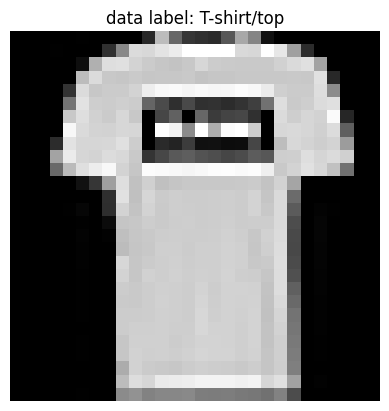

In [7]:
view_sample_img(train_data, index=1, label_map=label_map)

## Create the dataloader

In [8]:
BATCH_SIZE = 64

train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

In [9]:
for data, label in test_data_loader:
    print(data.shape)    
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## CNN architecture

pytorch doc - [reference](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.Flatten = nn.Flatten()#flattening
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)#fully connected layers
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)
        
    
    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = self.FC_02(x)        
        x = self.FC_03(x)
        return x

In [23]:
model = CNN(1, 10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

## Count no. of trainable params

In [24]:
def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = 0
    for name, parameters in model.named_parameters():
        if not parameters.requires_grad:
            continue
        param = parameters.numel()
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total trainable parameters: {total}")
    return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


## Traning loop

In [17]:
learning_rate = 0.001
num_epochs = 20

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [20]:
60000/BATCH_SIZE

937.5

In [25]:
for epoch in range(num_epochs):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            
            images = images.to(device)
            labels = labels.to(device)   
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/20: 100%|██████████| 938/938 [00:40<00:00, 23.13it/s, loss=2.32]


## save trained model -

In [26]:
## save trained model -
os.makedirs("06_03_session_dir", exist_ok=True)
modle_file = os.path.join("06_03_session_dir", 'CNN_model.pth')
torch.save(model, modle_file)

In [27]:
model = torch.load("06_03_session_dir/CNN_model.pth")

In [28]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        image, label = data[0].to(device), data[1].to(device)
        
        y_pred = model(image)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, label.cpu().numpy()))

In [29]:
cm = confusion_matrix(target, pred)

<AxesSubplot:>

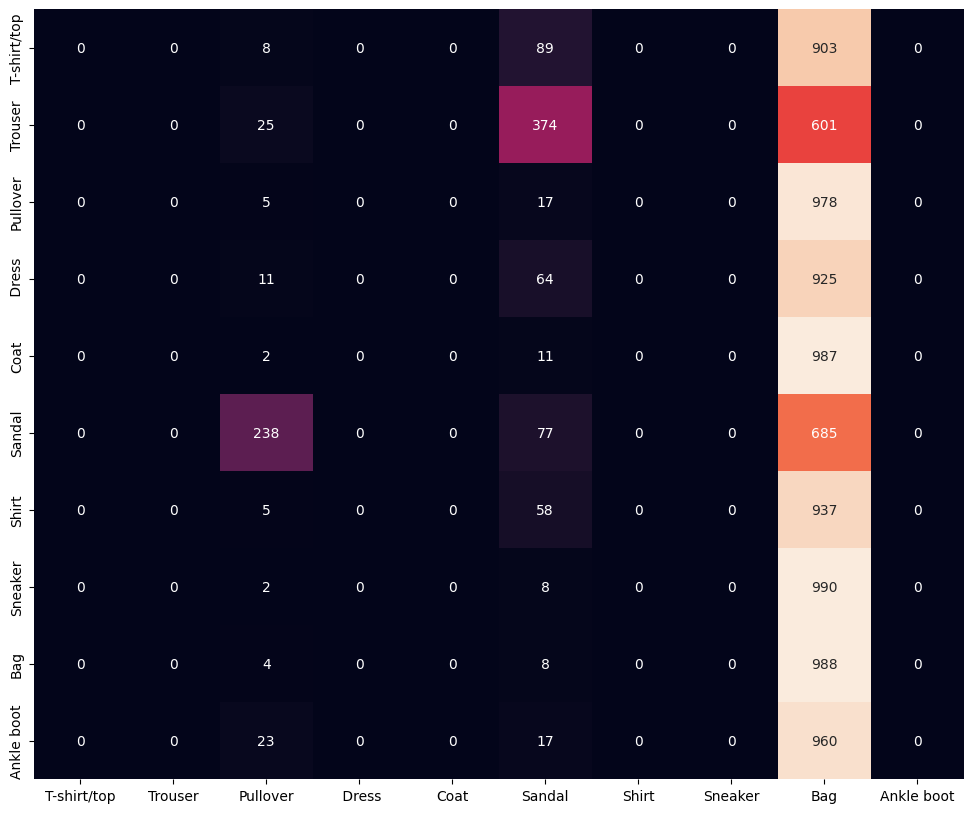

In [30]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cbar=False)

## predictions

In [31]:
data = next(iter(test_data_loader))
data

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

torch.Size([1, 28, 28])


' Dress'

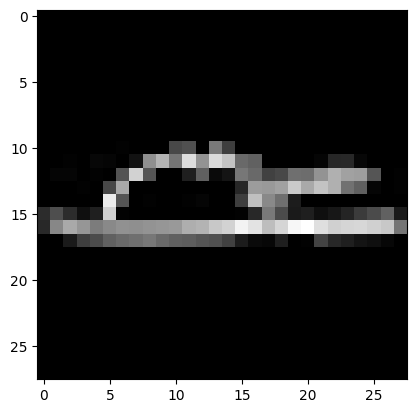

In [32]:
img = images[0]
print(img.shape)
plt.imshow(img.permute(1,2,0), cmap="gray")
label_map[label[0].item()]

In [33]:
img.shape, img.squeeze().shape, img.unsqueeze(1).shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

In [34]:
logit = model(img.unsqueeze(1).to(device))
logit

tensor([[ 0.0715,  0.0780,  0.1077,  0.0525,  0.0266,  0.0905, -0.0132, -0.0855,
          0.1010, -0.0246]], grad_fn=<AddmmBackward0>)

In [35]:
sum([ 7.1967, -2.9418,  2.8013,  3.3049, -1.9232, -3.9252,  2.8830, -6.2832,
         -6.1457, -8.0098])

-13.043000000000001

In [36]:
pred_prob = F.softmax(logit, dim=1)
pred_prob

tensor([[0.1030, 0.1036, 0.1068, 0.1010, 0.0984, 0.1049, 0.0946, 0.0880, 0.1061,
         0.0935]], grad_fn=<SoftmaxBackward0>)

In [37]:
sum([9.5575e-01, 3.7780e-05, 1.1789e-02, 1.9506e-02, 1.0463e-04, 1.4131e-05,
         1.2792e-02, 1.3369e-06, 1.5341e-06, 2.3784e-07])

0.9999966498400003

In [38]:
argmax = torch.argmax(pred_prob).item()
argmax

2

In [39]:
label_map[argmax]

'Pullover'

In [41]:
def predict(data, model, label_map, device, idx=0):
    images, labels = data
    img = images[idx]
    label = labels[idx]
    
    plt.imshow(img.permute(1,2,0), cmap="gray")
    reshaped_img = img.unsqueeze(1).to(device)
    logits = model(reshaped_img)
    pred_prob = F.softmax(logits, dim=1)
    argmax = torch.argmax(pred_prob).item()
    predicted_label = label_map[argmax]
    actual_label = label_map[label.item()]
    plt.title(f"actual: {actual_label} | predicted: {predicted_label}")
    return predicted_label, actual_label

('Bag', 'T-shirt/top')

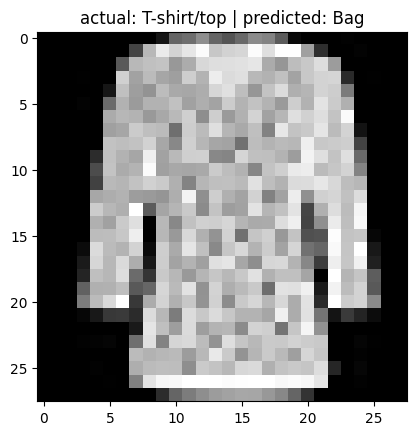

In [42]:
data = next(iter(test_data_loader))
predict(data, model, label_map, device, idx=0)

In [ ]:
# [batch_size, channel, row, col] -->> [1,1,28,28]